In [1]:
import numpy
import pandas as pd
import torch
import numpy as np
#from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os
import torchvision.transforms as T
import csv
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from torch.utils.tensorboard import SummaryWriter #tensorboard --logdir log --bind_all


In [2]:
def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    file = pd.read_csv(r'datalabel-class.csv',index_col=0)
    labels=[]
    img_data = []
    for file_name in os.listdir(dir):
        if file_name != "Thumbs.db":
            img_dir = os.path.join(dir, file_name)
            img = cv2.imread(img_dir)
            #img = cv2.resize(img, (800, 800))   # /5 resize img
            #img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
            pimg = Image.fromarray(img)
            img_data.append(pimg)
            for index, data in file.iterrows():       #add label
                if file_name[-8:-4] == index[-8:-4]:
                    labels.append(np.array(data))
    labels = torch.tensor(labels)
    labels = labels.type(torch.FloatTensor)
    #labels = labels.unsqueeze(1)
    return img_data,labels

In [3]:
traindir= './train/'
validdir='./valid/'
testdir='./test/'
train_rdata, train_label = generate_dataset(traindir)
valid_rdata, valid_label = generate_dataset(validdir)

C:\Users\brdgadmin\AppData\Local\Temp\ipykernel_19252\3851490576.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  labels = torch.tensor(labels)


In [4]:
print(len(valid_rdata),len(valid_label))
print(len(train_rdata),len(train_label))
print(train_rdata[0],train_label[0])
print(train_label.shape)


400 400
1600 1600
<PIL.Image.Image image mode=RGB size=1200x1200 at 0x1C9981C9E10> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0.])
torch.Size([1600, 24])


In [5]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            im_tensor = transform(data[i])#.to(torch.device("cpu"))
            imgs.append((im_tensor, labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)

In [6]:
normMean = [0.5]
normStd = [0.5]
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]
    #transforms.Normalize(normMean, normStd)
    ])

# 也可以再定义train_transform加入一些数据增强
train_data = MyDataset(train_rdata, train_label, transform=transform)
valid_data = MyDataset(valid_rdata, valid_label, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=8, shuffle=True)
dataiter=iter(train_loader)
images, labels = dataiter.__next__()
print(images.shape)
print(labels.shape)

torch.Size([8, 1, 448, 448])
torch.Size([8, 24])


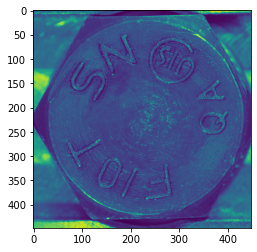

In [7]:
topic = T.ToPILImage()
imm1 = topic(images[3])
plt.imshow(imm1)

# Defin network

In [8]:
# todo Bottleneck
class Bottleneck(nn.Module):
    """
    __init__
        in_channel：残差块输入通道数
        out_channel：残差块输出通道数
        stride：卷积步长
        downsample：在_make_layer函数中赋值，用于控制shortcut图片下采样 H/2 W/2
    """
    expansion = 4   # 残差块第3个卷积层的通道膨胀倍率
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1, bias=False)   # H,W不变。C: in_channel -> out_channel
        self.bn1 = nn.BatchNorm2d(num_features=out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=stride, bias=False, padding=1)  # H/2，W/2。C不变
        self.bn2 = nn.BatchNorm2d(num_features=out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion, kernel_size=1, stride=1, bias=False)   # H,W不变。C: out_channel -> 4*out_channel
        self.bn3 = nn.BatchNorm2d(num_features=out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        identity = x    # 将原始输入暂存为shortcut的输出
        if self.downsample is not None:
            identity = self.downsample(x)   # 如果需要下采样，那么shortcut后:H/2，W/2。C: out_channel -> 4*out_channel(见ResNet中的downsample实现)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity     # 残差连接0 n
        out = self.relu(out)

        return out
class ResNet(nn.Module):
    """
    __init__
        block: 堆叠的基本模块
        block_num: 基本模块堆叠个数,是一个list,对于resnet50=[3,4,6,3]
        num_classes: 全连接之后的分类特征维度

    _make_layer
        block: 堆叠的基本模块
        channel: 每个stage中堆叠模块的第一个卷积的卷积核个数，对resnet50分别是:64,128,256,512
        block_num: 当期stage堆叠block个数
        stride: 默认卷积步长
    """
    def __init__(self, block, block_num, num_classes):
        super(ResNet, self).__init__()
        self.in_channel = 64    # conv1的输出维度

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)     # H/2,W/2。C:3->64
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # H/2,W/2。C不变
        self.layer1 = self._make_layer(block=block, channel=64, block_num=block_num[0], stride=1)   # H,W不变。downsample控制的shortcut，out_channel=64x4=256
        self.layer2 = self._make_layer(block=block, channel=128, block_num=block_num[1], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=128x4=512
        self.layer3 = self._make_layer(block=block, channel=256, block_num=block_num[2], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=256x4=1024
        self.layer4 = self._make_layer(block=block, channel=512, block_num=block_num[3], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=512x4=2048

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # 将每张特征图大小->(1,1)，则经过池化后的输出维度=通道数
        self.fc1 = nn.Linear(in_features=512*block.expansion, out_features=1024) #in=2048,out=1024
        self.dropout = nn.Dropout(0.5) #dropout rate
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes) #in=1024, out=1
        #self.fc3 = nn.Linear(in_features=512, out_features=1) #in=512, out=1
        #self.fc4 = nn.Linear(in_features=128, out_features=num_classes) #in=128, out=1

        for m in self.modules():    # 权重初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None   # 用于控制shorcut路的
        if stride != 1 or self.in_channel != channel*block.expansion:   # 对resnet50：conv2中特征图尺寸H,W不需要下采样/2，但是通道数x4，因此shortcut通道数也需要x4。对其余conv3,4,5，既要特征图尺寸H,W/2，又要shortcut维度x4
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False), # out_channels决定输出通道数x4，stride决定特征图尺寸H,W/2
                nn.BatchNorm2d(num_features=channel*block.expansion))

        layers = []  # 每一个convi_x的结构保存在一个layers列表中，i={2,3,4,5}
        layers.append(block(in_channel=self.in_channel, out_channel=channel, downsample=downsample, stride=stride)) # 定义convi_x中的第一个残差块，只有第一个需要设置downsample和stride
        self.in_channel = channel*block.expansion   # 在下一次调用_make_layer函数的时候，self.in_channel已经x4

        for _ in range(1, block_num):  # 通过循环堆叠其余残差块(堆叠了剩余的block_num-1个)
            layers.append(block(in_channel=self.in_channel, out_channel=channel))

        return nn.Sequential(*layers)   # '*'的作用是将list转换为非关键字参数传入

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        #x = F.softmax(x,dim=0)
        #x = self.fc3(x)
        # x = self.sigmoid(x)
        # x = self.fc4(x)
        return x

## resnet 152

In [9]:
# ##########################
# ### MODEL
# ##########################


# def conv3x3(in_planes, out_planes, stride=1):
#     """3x3 convolution with padding"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
#                      padding=1, bias=False)


# class Bottleneck152(nn.Module):
#     expansion = 4

#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(Bottleneck152, self).__init__()
#         self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
#                                padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(planes * 4)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.relu(out)

#         return out




# class ResNet152(nn.Module):

#     def __init__(self, block, layers, num_classes, in_dim):
#         self.inplanes = 64

#         super(ResNet152, self).__init__()
#         self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
#         self.fc = nn.Linear(2048 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, (2. / n)**.5)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for i in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         logits = self.fc(x)
#         probas = F.softmax(logits, dim=1)
#         return logits, probas


In [10]:
# acc = 0.0
# with torch.no_grad():
#         #for i, (images, labels) in enumerate(valid_loader, 0):
#         #images, labels = dataiter.next()
#         # 输入数据进行预测
#         images, labels = next(iter(valid_loader))
#         # get the inputs
#         images = Variable(images.to(device))
#         labels = Variable(labels.to(device))
#         outputs = net(images)
#         predict_y = torch.max(outputs, dim=1)[1]
#         loclabe = torch.max(labels, dim=1)[1]
#         acc += (predict_y == loclabe).sum().item()
#         loss=loss_func(outputs, labels)
#         loss += loss.item()
#         sf=F.softmax(outputs,dim=1)
#         print(acc)
#         print(loclabe)
#         print(predict_y)
#         preloss = np.mean(loss.data.cpu().numpy()) #preloss = loss/(i+1)
#         acc_test = acc / len(valid_label)

In [11]:
def testAccuracy():
    acc = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    x=[]
    y=[]
    np.array(x)
    np.array(y)
    # net=torch.load('')
    net.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader, 0):
            #images, labels = dataiter.next()
            # 输入数据进行预测
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            outputs = net(images)
            predict_y = torch.max(outputs, dim=1)[1]
            loclabe = torch.max(labels, dim=1)[1]
            acc += (predict_y == loclabe).sum().item()
            loss=loss_func(outputs, labels)
            loss += loss.item()

    preloss = np.mean(loss.data.cpu().numpy()) #preloss = loss/(i+1)
    acc_test = acc / len(valid_label)

    # if acc_test > best_acc:
    #     # 更新最佳的准确率
    #     best_acc = acc_test
    #     # 保存的权重名称
    #     savename = casename+'-bset.pth'
    #     # 保存当前权重
    #     torch.save(net.state_dict(), savename)
        
    return(acc_test,preloss)
    


def train(num_epochs,device):
    import time
    start_time = time.process_time()
    best_accuracy = 0.0

    # Define your execution device
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    k=0
    predata=[]
    labeldata=[]
    mseloss=[]
    trainnum=[]
    epochout=[]
    epochV=[]
    vloss=[]
    validaccs=[]
    # Convert model parameters and buffers to CPU or Cuda
    net.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        
        for i, (images, labels) in enumerate(train_loader, 0):
            #images, labels = dataiter.next()
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            prediction = net(images)
            #print(prediction,labels)
            #print('Prediction data is:',prediction.data.cpu().numpy()[0])
            #print('label data is: ',labels.data.cpu().numpy())
            # 计算预测值与真值误差，注意参数顺序问题
            # 第一个参数为预测值，第二个为真值
            loss = loss_func(prediction, labels)
            # 开始优化步骤
            # 每次开始优化前将梯度置为0
            optimizer.zero_grad()
            # 误差反向传播
            loss.backward()
            # 按照最小loss优化参数
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 10 == 0:
                # print every 1000 (twice per epoch)
                #print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")
                print('[Epoch: %d/%d]- %d/%d | loss: %.3f |' %
                      (epoch + 1,num_epochs, i + 1,len(train_loader), running_loss / 10))
                mseloss.append(running_loss/10)
                trainnum.append(i+1)
                epochout.append(epoch+1)
                result=pd.DataFrame({'epoch':epochout,'trainnum':trainnum,'loss':mseloss})
                result.to_csv("result.csv",index=False,sep=',')
                
                # Tensorboard
                writer.add_scalar('Training loss',running_loss / 10,epoch * len(train_loader) + i)
                # writer.add_figure('predictions vs. actuals',
                #             plot_classes_preds(net, inputs, labels),
                #             global_step=epoch * len(trainloader) + i)
                # zero the loss
                running_loss = 0.0

            predata.append(prediction.data.cpu().numpy()[0])
            labeldata.append(labels.data.cpu().numpy()[0])

        validacc,validloss = testAccuracy()
        vloss.append(validloss)
        validaccs.append(validacc)
        epochV.append(epoch+1)
        writer.add_scalar('valid_loss',validloss,epoch+1)
        writer.add_scalar('valid_ACC',validacc,epoch+1)
        vresult=pd.DataFrame({'epoch':epochV,'vloss':vloss,'validacc':validaccs})
        vresult.to_csv("result-valid.csv",index=False,sep=',')
        print('[Epoch: %d/%d] ======>| Valid Loss: %.3f ,valid_ACC is %.3f' % (epoch+1,num_epochs,validloss,validacc))
      
    print('Finished Training')
    ttime=(np.array(epochout)-1)*len(train_loader)+np.array(trainnum)
    plt.figure()
    plt.legend()
    plt.grid(True)
    plt.ylim(0,0.1)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("train times")
    plt.plot(ttime,mseloss)
    plt.savefig('tranloss.png', dpi=1200) 
    end_time = time.process_time()
    print("Use time:", (end_time-start_time)/3600)


In [12]:
Vdataiter=iter(valid_loader)#valid_loader
vimg, vlabels = Vdataiter.next()
print(vimg.shape)
print(vlabels.shape)
print(vlabels)

torch.Size([8, 1, 448, 448])
torch.Size([8, 24])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])


In [13]:
def predict(model, device,dataloder):
    Vdataiter=iter(dataloder)
    vimg, vlabels = Vdataiter.next()
    model.to(device)
    with torch.no_grad():
        vimg=vimg.to(device)
        out = model(vimg)
        _, pre = torch.max(out.data, 1)
        return out, vlabels

# defin model

In [14]:
# 输入输出的数据维度，这里都是1维
INPUT_FEATURE_DIM = 5000
# 隐含层中神经元的个数
#NEURON_NUM = 500
#OUTPUT_FEATURE_DIM = 1
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.0002
# 保存准确率最高的一次迭代
best_acc = 0.0
# 定义模型
#net = Net()
net = ResNet(block=Bottleneck, block_num=[3,4,6,3],num_classes=24)
#net = ResNet152(block=Bottleneck152,layers=[3, 4, 36, 3],num_classes=1,in_dim=3)
casename='case5'
writer = SummaryWriter("./log/"+casename) #tensorboard

#print(net)
writer.add_graph(net, images)
writer.close()

# 训练网络
# 这里也可以使用其它的优化方法
#optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.SGD(net.parameters(),lr=LEARNING_RATE)
# 定义一个误差计算方法
#loss_func = torch.nn.MSELoss()
loss_func = nn.CrossEntropyLoss() #定义交叉熵损失函数 交叉熵损失函数是用来衡量两个概率分布之间的距离的#nn.MSELoss()
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

#summary(model, input_size=[(3,224,224)], device='cpu') #from torchsummary import summary
print(net)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_s

In [15]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to(device)
# # for i, (images, labels) in enumerate(train_loader, 0):
# #     #images, labels = dataiter.next()
# #     # get the inputs
# #     images = Variable(images.to(device))
# #     labels = Variable(labels.to(device))
# #prediction = net(images)
# print(labels.shape)
# print(prediction.shape)

# main

In [17]:
 # Vdataiter=iter(valid_loader)
# vimg, vlabels = Vdataiter.next()
# print(vimg.shape)
# print(vlabels.shape)
# print(vlabels)
if __name__ == "__main__":

    best_acc=0.0
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    # Let's build our model
    train(2000,device)
    print('Finished Training')
    #Epochごとのlossの保存
    torch.save(net, casename+'.pt')
    # 保存网络中的参数, 速度快，占空间少
    #torch.save(net.state_dict(),'case-1-p.pt')
    #--------------------------------------------------
    #针对上面一般的保存方法，加载的方法分别是：
    # model_dict=torch.load(PATH)
    # model_dict=model.load_state_dict(torch.load(PATH))
    # Test which classes performed well
    testAccuracy()

    # Let's load the model we just created and test the accuracy per label
    # model = net()
    # path = "myFirstModel.pth"
    # model.load_state_dict(torch.load(path))


[Epoch: 1/2000]- 10/200 | loss: 3.010 |
[Epoch: 1/2000]- 20/200 | loss: 3.068 |
[Epoch: 1/2000]- 30/200 | loss: 3.013 |
[Epoch: 1/2000]- 40/200 | loss: 3.050 |
[Epoch: 1/2000]- 50/200 | loss: 3.046 |
[Epoch: 1/2000]- 60/200 | loss: 3.070 |
[Epoch: 1/2000]- 70/200 | loss: 3.078 |
[Epoch: 1/2000]- 80/200 | loss: 3.101 |
[Epoch: 1/2000]- 90/200 | loss: 3.106 |
[Epoch: 1/2000]- 100/200 | loss: 3.068 |
[Epoch: 1/2000]- 110/200 | loss: 3.086 |
[Epoch: 1/2000]- 120/200 | loss: 3.067 |
[Epoch: 1/2000]- 130/200 | loss: 3.045 |
[Epoch: 1/2000]- 140/200 | loss: 3.017 |
[Epoch: 1/2000]- 150/200 | loss: 3.040 |
[Epoch: 1/2000]- 160/200 | loss: 3.009 |
[Epoch: 1/2000]- 170/200 | loss: 3.031 |
[Epoch: 1/2000]- 180/200 | loss: 3.042 |
[Epoch: 1/2000]- 190/200 | loss: 3.053 |
[Epoch: 1/2000]- 200/200 | loss: 3.050 |
[Epoch: 1/2000] ======>| Valid Loss: 6.605 ,valid_ACC is 0.098
[Epoch: 2/2000]- 10/200 | loss: 3.039 |
[Epoch: 2/2000]- 20/200 | loss: 3.045 |
[Epoch: 2/2000]- 30/200 | loss: 3.062 |
[Epoch

# Visualization

In [ ]:
acc = 0.0
total = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
net.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader, 0):
        #images, labels = dataiter.next()
        # 输入数据进行预测
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
        outputs = net(images)
        predict_y = torch.max(outputs, dim=1)[1]
        acc += (predict_y == labels).sum().item()
        loss=loss_func(outputs, labels)
        loss += loss.item()

preloss = np.mean(loss.data.cpu().numpy()) #preloss = loss/(i+1)
acc_test = acc / len(valid_label)

if acc_test > best_acc:
    # 更新最佳的准确率
    best_acc = acc_test
    # 保存的权重名称
    savename = casename+'-bset.pth'
    # 保存当前权重
    torch.save(net.state_dict(), savename)


RuntimeError: The size of tensor a (8) must match the size of tensor b (24) at non-singleton dimension 1

Optimal Values
a: 0.6582648889096415
b: 18.92518985957328
R^2: 0.7068357413720928
testdataNum:45
preloss:tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
Uncertainty
a: 0.658+/-0.014
b: 18.9+/-0.9
MSE:= 481.5924640315068 | RMSE: 21.945215060042287 |msle: 0.23830226926403167 |mae: 15.250308592417001 |r2: 0.5305957439817574


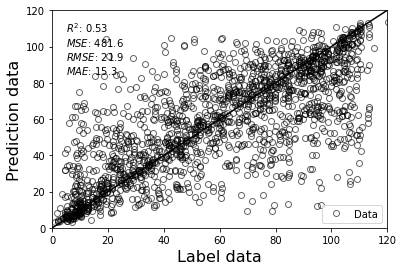

In [ ]:

x=np.linspace(0,120,120)
y=np.linspace(0,120,120)

from scipy.optimize import curve_fit
from scipy import stats
import uncertainties.unumpy as unp
import uncertainties as unc
import seaborn as sns

plt.figure()

plt.xlim(0,120)
plt.ylim(0,120)
#y_err1=1.1*train_label.data.cpu().numpy()
#y_err2=0.9*train_label.data.cpu().numpy()
#n = len(y)
xx=x0
yy=y0
n = len(yy)

def f(x, a, b):
    return np.multiply(a, x) + b

#popt, pcov = curve_fit(f, x, y)
popt, pcov = curve_fit(f, xx, yy)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
#r2 = 1.0-(sum((y0-f(x0,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
r2 = 1.0-(sum((yy-f(xx,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))
print('testdataNum:' + str(i+1))
print('preloss:' + str(preloss))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))



mse = np.mean((x0 - y0) ** 2)
rmse = np.sqrt(np.mean((x0 - y0) ** 2))
msle = np.mean((np.log1p(x0) - np.log1p(y0))** 2)
mae = np.mean(np.abs(x0 - y0))
r2 = 1 - np.mean((x0 - y0) ** 2) / np.mean((x0 - x0.mean()) ** 2)
print('MSE:=',mse,'| RMSE:',rmse,'|msle:',msle,'|mae:',mae,'|r2:',r2)

# calculate regression confidence interval
px=np.linspace(0,120,120)
py=a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

#plt.fill_between(df['temperature'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=.1, label='Prediction interval')
# prediction band (95% confidence)

# plot the regression
#plt.plot(px, nom, c='black', label='Regression Line')

lpb, upb = predband(px, xx, yy, popt, f, conf=0.95)


#lpb=[x+25 for x in px]
#upb=[x-25 for x in px]

# uncertainty lines (95% confidence)
#plt.plot(px, nom - 1.96 * std, c='orange',\
#        label='95% Confidence Region')
#plt.plot(px, nom + 1.96 * std, c='orange')

# prediction band (95% confidence)
#plt.plot(px, lpb, 'k--',label='95% Prediction Band')
#plt.plot(px, upb, 'k--')
#plt.fill_between(px,lpb,upb, alpha=.1,)

# plot data

plt.plot(x0,y0,'ko',alpha=0.6,label='Data', mfc='none')


plt.plot(x, y, c='black')
#plt.plot(x*0.9,y,'k--',label='90% Error interval')
#plt.plot(x*1.1,y,'k--')
#plt.fill_between(x,x*1.1,x*0.9, alpha=.1)
plt.legend(loc='lower right')
plt.xlabel('Label data',fontsize=16)
plt.ylabel('Prediction data',fontsize=16)
text='$R^2$: {:.2f} \n$MSE$: {:.1f} \n$RMSE$: {:.1f} \n$MAE$: {:.1f}'.format(r2,mse,rmse,mae)
plt.text(5,85,text)
plt.savefig('predictpreload.png', dpi=1200)
plt.show()
torch.save(net, casename+'.pt')

In [ ]:
print(len(x0))

1765


In [ ]:
test_rdata, test_label = generate_dataset(testdir)
test_data = MyDataset(test_rdata, test_label, transform=transform)
test_loader = DataLoader(dataset=test_data, batch_size=4, shuffle=True)
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(test_loader, 0):
    #images, labels = dataiter.next()
    # 输入数据进行预测
    # get the inputs
    images = Variable(images.to(device))
    labels = Variable(labels.to(device))
    predata = net(images)
    #predata, labedata = predict(net, valid_loader)
    loss=loss_func(predata, labels)
    loss += loss.item()
    x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
    y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
    preloss=loss/(i+1)


<function matplotlib.pyplot.show(close=None, block=None)>

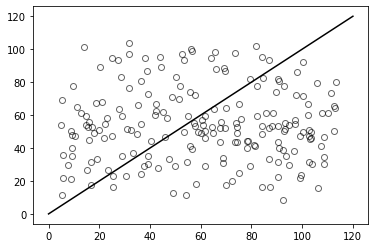

In [ ]:
x0=np.linspace(0,120,120)
y0=np.linspace(0,120,120)
plt.plot(x0, y0, c='black')
plt.plot(x*116,y*116,'ko',alpha=0.6,label='Data', mfc='none')
plt.show

In [ ]:
print(len(x))

200
